# Single-layer ODE ConcatSquash2D

denpendencies: [neuode](https://github.com/mIXs222/neuode) and [torchdiffeq](https://github.com/rtqichen/torchdiffeq/)

In [19]:
import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import cv2
import tifffile as tiff
from functools import reduce, partial
import itertools
from skimage.measure import block_reduce

In [20]:
from neuode.interface.struct import (
    ODEBlockSpec, FFJORDProbDMapSpec,
    ActivationFn, DivSpec,
)
from neuode.dynamics.conv import ConcatSquashConv2d
from neuode.dynamics.composite import SequentialListDMap
from neuode.dynamics.odeblock import ODEBlock
from neuode.dynamics.ffjord_block import FFJORDProbDMap, FFJORDBlock
from neuode.util.util import actfn2nn

In [40]:
# REPLACE with your directory containing the microscopy slides
MROOT = '../data/microscopy'

## Load Data

Extract data from disk. You can igonre this part and look at the format of raw image (`allrimg`) and label (`allalllabel`) afterwards.

In [9]:
# unpack given info
class SlideFetcher:
    def __init__(self, name, labels, where):
        self.name = name
        self.labels = labels
        self.label2where = dict()
        for l, w in zip(labels, where):
            self.label2where[l] = w
            
    def __getitem__(self, key):
        return self.get_img(key)
            
    def get_img(self, label):
        return tiff.imread(self.label_path(label))
            
    def label_path(self, label):
        return self.label2where[label]

# discover slide files under MROOT
slides = dict()
for d in os.listdir(MROOT):
    subpath = os.path.join(MROOT, d)
    for dslide in os.listdir(subpath):
        subpathslide = os.path.join(subpath, dslide)
        labels, where = [], []
        for dimg in os.listdir(subpathslide):
            if dslide in dimg:
                label_name = dimg[len(dslide)+1:]
                if label_name == 'tif':
                    label_name = '__raw__'
                elif label_name.endswith('.tiff'):
                    label_name = label_name[:-5]
                labels.append(label_name)
                where.append(os.path.join(subpathslide, dimg))
        slides[dslide] = SlideFetcher(dslide, labels, where)
slides

{'CL_T4R_180807_01': <__main__.SlideFetcher at 0x7f1ac585f208>,
 'NA_T4R_122117_19': <__main__.SlideFetcher at 0x7f1ac585fcf8>,
 'CL_T4R_180824_02': <__main__.SlideFetcher at 0x7f1ac585f240>,
 'CL_T4R_180807_06': <__main__.SlideFetcher at 0x7f1b0333d668>,
 'CL_T4R_180824_05': <__main__.SlideFetcher at 0x7f1ac585f940>,
 'NA_T4R_122117_17': <__main__.SlideFetcher at 0x7f1ac585f630>,
 'S1_Helios_1of3_v1010': <__main__.SlideFetcher at 0x7f1ac585f668>,
 'S1_Helios_1of3_v1270': <__main__.SlideFetcher at 0x7f1ac585f828>,
 'NA_T4_122117_11': <__main__.SlideFetcher at 0x7f1ac585fb70>,
 'NA_T4_122117_14': <__main__.SlideFetcher at 0x7f1ac585f898>,
 'NA_T4_122117_15': <__main__.SlideFetcher at 0x7f1ac585f470>,
 'NA_T4_122117_13': <__main__.SlideFetcher at 0x7f1ac585f908>,
 'NA_T4_122117_01': <__main__.SlideFetcher at 0x7f1ac585fbe0>}

In [17]:
allskey = list(slides.keys())[5:8]  # sample only 3 of them
nlabel = 1
label2val = {'Background': 0}
val2label = {0: 'Background'}
allalllabel = []
allrimg = []
for skey in allskey:
    tlabel = slides[skey].labels[3]
    rimg = slides[skey]['__raw__']

    alllabel = np.zeros(rimg.shape, dtype=int)
    for l in slides[skey].labels:
        if l == '__raw__': continue
        limg = slides[skey][l]
        if l not in label2val:
            label2val[l] = nlabel
            val2label[nlabel] = l
            nlabel += 1
        alllabel[limg != 0] = label2val[l]
        del limg
    
    allalllabel.append(alllabel)
    allrimg.append(rimg)

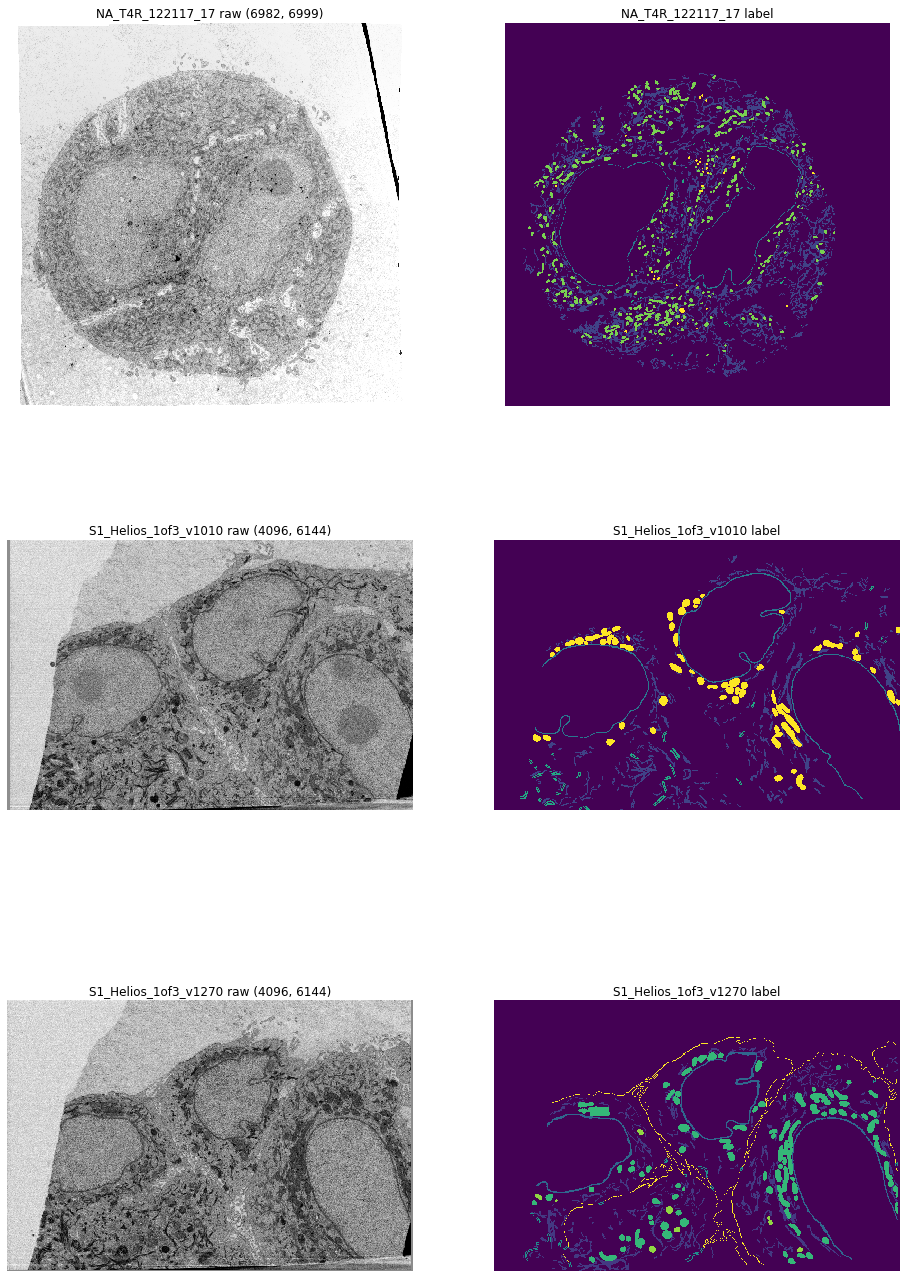

In [18]:
N, SZ = len(allskey), 8
fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(2*SZ, N*SZ))
for axs, alllabel, rimg, name in zip(axes, allalllabel, allrimg, allskey):
    axs[1].imshow(alllabel[::8, ::8])
    axs[1].set_title(f'{name} label')
    axs[0].imshow(rimg[::8, ::8], cmap='gray')
    axs[0].set_title(f'{name} raw {rimg.shape}')
for ax in axes.flatten():
    ax.axis('off')

### Get a patch to test overfitting

In [26]:
def alllabel2onehot(y, nclass):
    py = np.zeros(y.shape + (nclass,))
    for c in range(nclass):
        py[..., c][y == c] = 1.0
    py = np.transpose(py, (2, 0, 1))
    return py


def extract_window(lx, rx, ly, ry, nclass, dsr=1):
    if dsr == 1:
        return ximg[lx:rx:dsr, ly:ry:dsr], \
            ylabel[lx:rx:dsr, ly:ry:dsr], \
            alllabel2onehot(ylabel[lx:rx, ly:ry], nclass)
    return ximg[lx:rx:dsr, ly:ry:dsr], \
        ylabel[lx:rx:dsr, ly:ry:dsr], \
        block_reduce(alllabel2onehot(ylabel[lx:rx, ly:ry], nclass), (1, dsr, dsr), np.mean)

    
def show_triplet(ximg_sel, ylabel_sel, yprob_sel, C=1, DSR=1):
    SZ = 6
    fig, axs = plt.subplots(ncols=3, figsize=(2*SZ, N*SZ))
    axs[0].imshow(ximg_sel[::DSR, ::DSR], cmap='gray')
    axs[0].set_title(f'{xname} raw {ximg_sel.shape}')
    axs[1].imshow(ylabel_sel[::DSR, ::DSR])
    axs[1].set_title(f'label')
    axs[2].imshow(yprob_sel[C, ::DSR, ::DSR])
    axs[2].set_title(f'class {C}')
    for ax in axs.flatten(): ax.axis('off')

In [27]:
IDX = 1
ximg = allrimg[IDX]
ylabel = allalllabel[IDX]
xname = allskey[IDX]
print(ximg.shape, ylabel.shape, xname)

(4096, 6144) (4096, 6144) S1_Helios_1of3_v1010


(100, 100) (100, 100) (8, 100, 100)


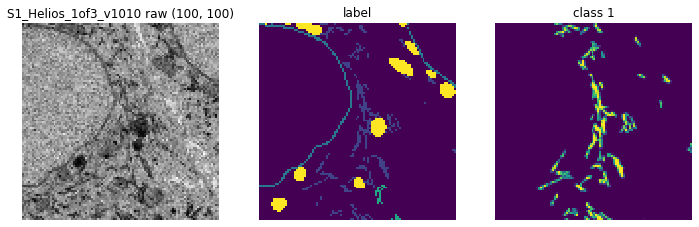

In [28]:
ximg_dsr, ylabel_dsr, yprob_dsr = extract_window(1600, 3200, 1600, 3200, 8, 16)
print(ximg_dsr.shape, ylabel_dsr.shape, yprob_dsr.shape)
show_triplet(ximg_dsr, ylabel_dsr, yprob_dsr)

## ODE ConcatSquash

In [31]:
def make_truncate_logpz(dim_latent, dim_reduce=None):
    def truncate_logpz(x):
        # compute prob only for the first dim_latent channels
        x = x[:, :dim_latent, ...]
        x = -x.pow(2)
        if dim_reduce != None:
            x = x.mean(dim_reduce, keepdim=True)
        return x
    return truncate_logpz


class MSegNet(nn.Module):
    
    def __init__(self, dim_in, dim_out):
        super(MSegNet, self).__init__()
        self.dim_out = dim_out
        
        # expand from image to higher-dim feature maps
        EXDIM = 64
        self.expand_cfn = nn.Sequential(
            nn.Conv2d(dim_in, EXDIM, kernel_size=3, stride=1, padding=1),
            actfn2nn(ActivationFn.RELU),
            nn.Conv2d(EXDIM, EXDIM, kernel_size=3, stride=1, padding=1),
            actfn2nn(ActivationFn.RELU),
        )

        # convolution dynamics
        MIDDIM = 128
        cdfn = SequentialListDMap([
            ConcatSquashConv2d(dim_out+EXDIM, MIDDIM, actfn=ActivationFn.TANH),
            ConcatSquashConv2d(MIDDIM, MIDDIM, actfn=ActivationFn.TANH),
            ConcatSquashConv2d(MIDDIM, dim_out+EXDIM, actfn=ActivationFn.NONE),
        ])
        self.cdfn_block = ODEBlock(
            cdfn,
            ODEBlockSpec(use_adjoint=True)
        )
    
        # log p(z) using only first d elements
        self.logpdf = make_truncate_logpz(self.dim_out, dim_reduce=None)
    
    
    def forward(self, x):
        # lift to higher-dim feature and prepend with latent variables
        x = self.expand_cfn(x)
        z = torch.zeros(x.shape[0], self.dim_out, x.shape[2], x.shape[3])
        x = torch.cat([z, x], 1)
        
        # step through dynamics
        logpx = self.cdfn_block(x)
        
        # turn to probability
        logpx = self.logpdf(logpx)
        
        return logpx

In [33]:
    segnet = MSegNet(1, 8)

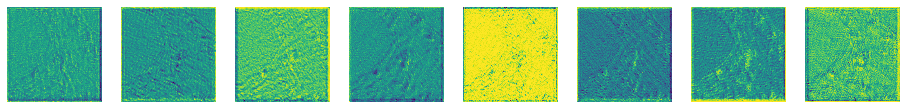

In [35]:
    def show_pred(logpx, cap=None):
        M, SZ = 8, 2
        N = (logpx.shape[0] - 1) // M + 1
        fig, axes = plt.subplots(nrows=N, ncols=M, figsize=(SZ*M, SZ*N)); axes = axes.flatten()
        for ax, lpx in zip(axes, logpx):
            if cap is None:
                ax.imshow(np.exp(lpx))
            else:
                z = np.zeros(lpx.shape); z[np.exp(lpx) > cap] = 1.0
                ax.imshow(z)
            ax.axis('off')

ximg_dsr_t = torch.Tensor(ximg_dsr)[None, None, ...]
yprob_dsr_t = torch.Tensor(yprob_dsr)[None, ...]

with torch.no_grad():
    logpx = segnet(ximg_dsr_t).detach().numpy()[0]
show_pred(logpx)

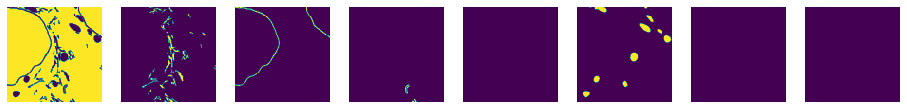

In [43]:
show_pred(yprob_dsr_t[0].detach().numpy())

Epoch   0: loss= 0.827463


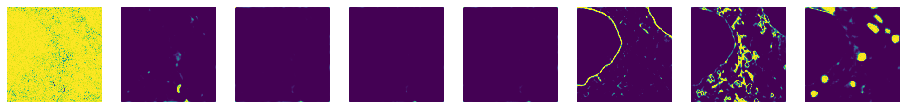

In [45]:
def extreme_loss(logpx, px_true):
    with torch.enable_grad():
        sum_class = 0.0
        for lpx, pxt in zip(logpx, px_true):
            px = torch.exp(lpx)
            true_idx = pxt > 0.5
            sum_class += -(torch.mean(lpx[true_idx]) - torch.mean(px[~true_idx]))
    return sum_class


NEPOCH = 1
LR = 0.01
optimizer = optim.SGD(segnet.parameters(), lr=LR, momentum=0.9)
for epoch in range(NEPOCH):
    optimizer.zero_grad()
    logpx = segnet(ximg_dsr_t)
    loss = extreme_loss(logpx, yprob_dsr_t)
    loss.backward()
    optimizer.step()
    
    print('Epoch %3d: loss= %f' % (epoch, loss.item()))
    if epoch % 10 == 0 or epoch == NEPOCH-1:
        show_pred(logpx[0].detach().numpy())
        plt.show()

# Train Script TODOs

## GPU
I haven't tested on GPU yet. Let me know if I need to modify `neuode` to enable this.

## Logs
Loss, MPA, IoU, also the pred images like above too.

## Save & Load
Save model every epoch by overwriting to the same file. Save to different file when finish. Before train, load model state from path by a flag (if flag not used, start from scratch). The training will potentially require many epochs that it won't fit in maverick's time limit per run.

## Other Configurables
- EXDIM and MIDDIM
- DSR, batch size, and patch sizes (width x height)
- optimization params (nepoch, lr, momentum, etc.)